First name : Adrien
Last name : Montaigne
Groupe : 2 (JOSEPH KODUAH, UZOECHI FREDERICK CHUKWUDI, KELVIN KIPKEMBOI and MY SELF)
APPLIED RESEARCH METHODOLOGY (MO007893) ELEMENT 010
SID : 2248806

**Step I : Import librairies** 

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import string
import nltk

from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('vader_lexicon')
from sklearn.cluster import KMeans
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud,STOPWORDS
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import random


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**Step II : Import dataset**

In [140]:
X = pd.read_csv("vaccination_tweets.csv")

**Step III : Check if it does not exist duplicate variable**

In [141]:
X.shape

(8082, 16)

In [142]:
myset = set(X['id'])
print(len(myset))

8082


We can see that there isn't a duplicate data because the number line is egal with the number of different id

**Step IV: Data Encoding**

In [143]:
X["source"] = X["source"].astype('category')

In [144]:
X["source"] = X["source"].cat.codes

In [145]:
X["user_verified"] = X["user_verified"].astype(int)


In [146]:
X["is_retweet"] = X["is_retweet"].astype(int)

**Step V: Extraction of the date**

In [147]:
X = X.sort_values(by='date')
X=X.copy()
X['date'] = pd.to_datetime(X['date']).dt.date

X["year"] = pd.DatetimeIndex(X['date']).year
X["month"] = pd.DatetimeIndex(X['date']).month
X["days"] = pd.DatetimeIndex(X['date']).day

we delete the feature "date" because it won't be useful

**Step VI : lowercase the text**

In [148]:
X['text']=X['text'].str.lower()

**Step VII : remove the links, numbers,special characters and punctuation,html characters, mentions, URLs, hashtags**

In [149]:
import re

X["text"] = X["text"].apply(lambda x:re.sub(r"http\S+", "", x))
X["text"] = X["text"].apply(lambda x:re.sub(r'\B#\S+','',x))
X["text"] = X["text"].apply(lambda x:re.sub('@[^\s]+','',x))
X["text"] = X["text"].apply(lambda x:' '.join(re.findall(r'\w+', x)))

**Step VIII: use VADER**

In [150]:
sid = SIA()
X['sentiments'] = X['text'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
X['Positive'] = X['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
X['Neutral'] = X['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
X['Negative'] = X['sentiments'].apply(lambda x: x['neg']+1*(10**-6))
X["vader_category"] = X["sentiments"].apply(lambda x: "Positive" if x['compound'] > 0.1 else "Negative" if x['compound'] < -0.1 else "Neutral")

**Step IX : remove columns**

In [151]:
X = X.drop(["id","user_name","user_location","user_description","user_created","date","sentiments","is_retweet","favorites","user_friends","source","user_favourites","retweets"], axis=1)

**Step X : correlation matrix**

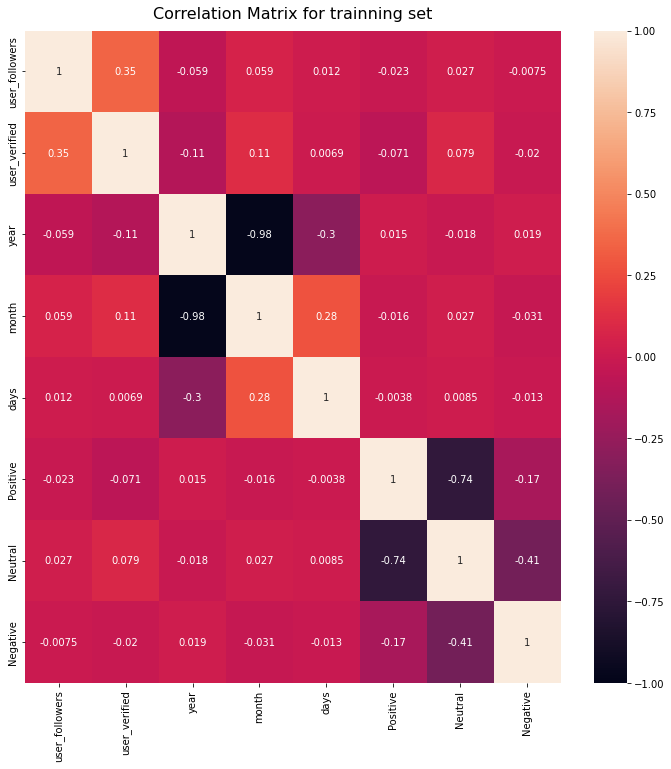

In [152]:
plt.figure(figsize=(12, 12))
heatmap = sns.heatmap(X.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Matrix for trainning set', fontdict={'fontsize':16}, pad=12);

we will focus on date, text and sentiment because the other feature are not useful. there isn't correlation between Negative, Positive, Neutral sentiment and the other feature.

The most part time, the tweet are neutral
there are twice more positive tweet than negative tweet

**Step XI : Data visualization about the number of tweet during a day**

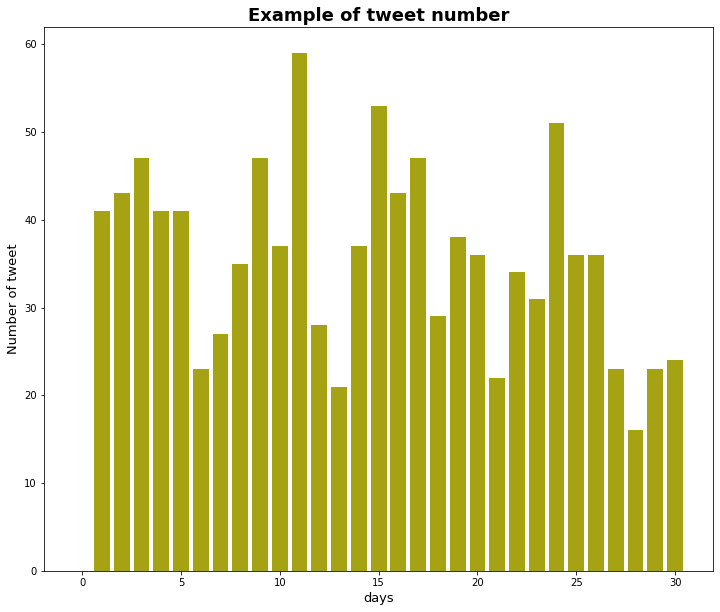

In [153]:
import random
random.seed(0)
x = X.loc[(X['month'] == 3) & (X['year'] == 2021), 'days']
inter = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 
         13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5, 22.5, 23.5, 24.5,
         25.5, 26.5, 27.5, 28.5, 29.5, 30.5]
f = plt.figure(figsize=(12, 10))
plt.hist(x, bins=inter, rwidth=0.8, color='#A5A313')  
plt.xlabel('days',fontsize = 13)
plt.ylabel('Number of tweet', fontsize = 13)
plt.title("Example of tweet number", fontsize = 18,fontweight='bold')
plt.show()

We can say that the number of tweets is not stationary depending on the day.

**Step XII : Data visualization about the average of feelings by month**

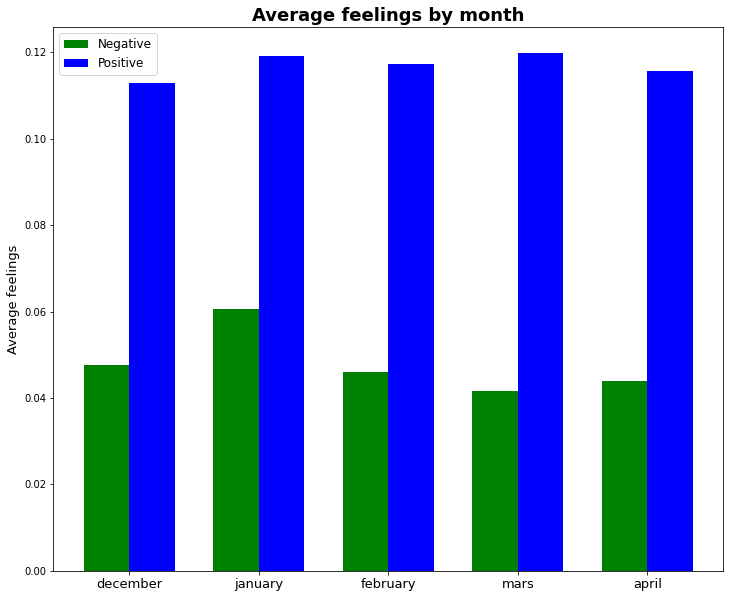

In [154]:
Mean_sentiment_Negative = [0]*5
Mean_sentiment_Positive = [0]*5
for i in range (0,5):
  Mean_sentiment_Positive[i] = X.loc[((X['month'] == i) & (X['year'] == 2021)) | ((X['month'] == i+12) & (X['year'] == 2020)) , 'Positive'].mean()
  Mean_sentiment_Negative[i] = X.loc[((X['month'] == i) & (X['year'] == 2021)) | ((X['month'] == i+12) & (X['year'] == 2020)) , 'Negative'].mean()

largeur_barre = 0.35 
names = ['december', 'january', 'february', 'mars', 'april']
x1 = range(len(names)) 
x2 = [i + largeur_barre for i in x1]
f = plt.figure(figsize=(12, 10))
plt.ylabel('Average feelings',fontsize = 13)
plt.title("Average feelings by month",fontsize = 18,fontweight='bold')
plt.bar(x1,Mean_sentiment_Negative,width=0.35, color = 'green', linewidth = 2)
plt.bar(x2, Mean_sentiment_Positive,width=0.35, color = 'blue', linewidth = 2)
plt.xticks([r + largeur_barre / 2 for r in range(len(x1))],names,fontsize = 13)
plt.legend(['Negative','Positive'],fontsize = 12)
plt.show()

We can observe that the number of negative tweets is clearly higher in January while the number of positive tweets does not vary according to the month.

We can wonder what happens in January and when exactly the number of negative tweets has increased.

**Step XIII : Data visualization about the average negative feelings by day during January**

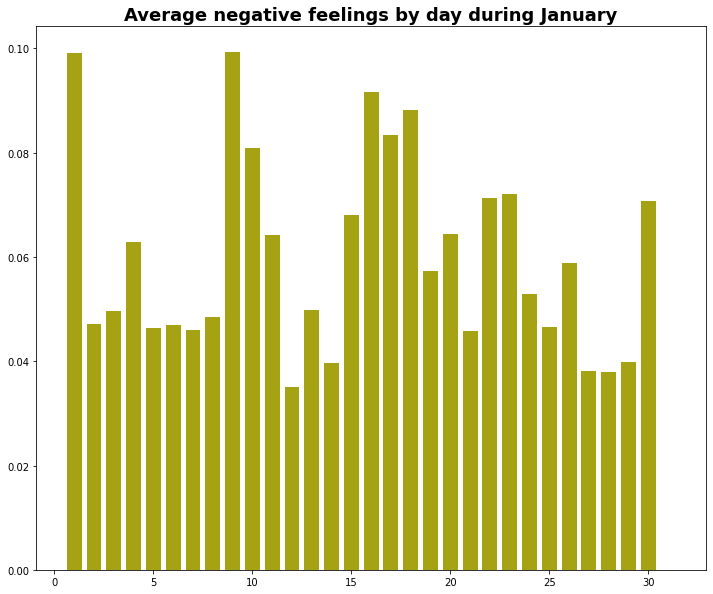

In [155]:
Mean_sentiment_Negative_daily = [0]*31
for i in range (1,31):
  Mean_sentiment_Negative_daily[i-1] = X.loc[((X['month'] == 1) & (X['year'] == 2021) & (X['days'] == i)) , 'Negative'].mean()
x1 = range(1,32) 
f = plt.figure(figsize=(12, 10))
plt.title("Average negative feelings by day during January",fontsize = 18,fontweight='bold')
plt.bar(x1,Mean_sentiment_Negative_daily,width=0.75, color = '#A5A313', linewidth = 2)
plt.show()

We can observe that between January 10th and 25th, the number of negative tweets has exploded. It corresponds to the beginning of vaccination around the world.

**Step XIV : Histogram on the popularity**

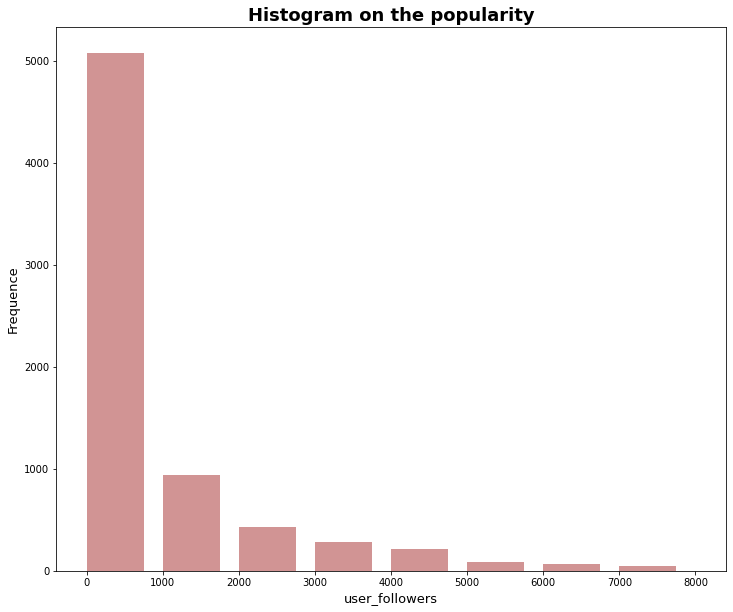

In [156]:
f = plt.figure(figsize=(12, 10))

plt.hist(X['user_followers'],bins=[0,1000,2000,3000,4000,5000,6000,7000,8000], width = 750, alpha=0.5, color='brown')
plt.xticks([0,1000,2000,3000,4000,5000,6000,7000,8000])
plt.title('Histogram on the popularity',fontsize = 18, fontweight = 'bold')
plt.xlabel('user_followers', fontsize = 13)
plt.ylabel('Frequence', fontsize = 13)
plt.show()

we can observe that most people don't have many followers (less than one thousand user_followers)

we will study what popular people think

**Step XV: Histogram on the average feelings in light of the popularity**

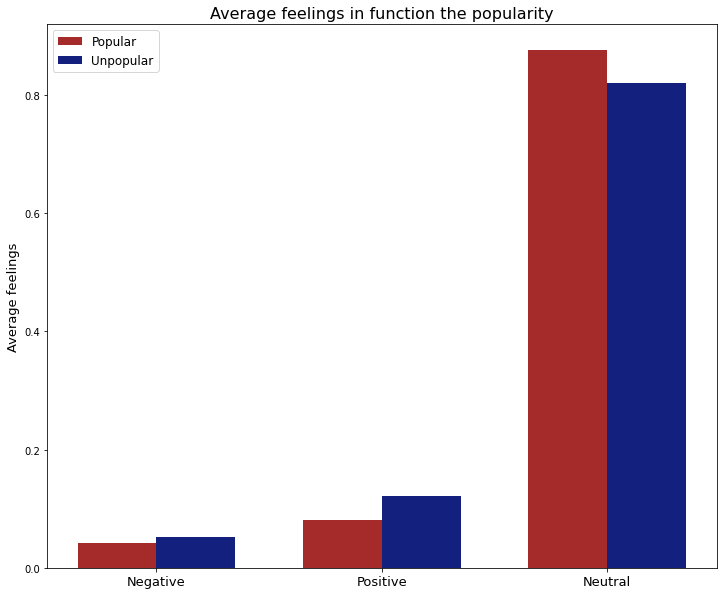

In [157]:
List_comparative_popular = [0]*3
List_comparative_none_popular = [0]*3

List_comparative_popular[0] = X.loc[(X['user_followers'] > 100000) ,'Negative'].mean()
List_comparative_none_popular[0] = X.loc[(X['user_followers'] < 10000) ,'Negative'].mean()
List_comparative_popular[1] = X.loc[(X['user_followers'] > 100000) ,'Positive'].mean()
List_comparative_none_popular[1] = X.loc[(X['user_followers'] < 10000) ,'Positive'].mean()
List_comparative_popular[2] = X.loc[(X['user_followers'] > 100000) ,'Neutral'].mean()
List_comparative_none_popular[2] = X.loc[(X['user_followers'] < 10000) ,'Neutral'].mean()

largeur_barre = 0.35 
names = ['Negative','Positive','Neutral']
x1 = range(len(names)) 
x2 = [i + largeur_barre for i in x1]
f = plt.figure(figsize=(12, 10))
plt.ylabel('Average feelings',fontsize = 13)
plt.title("Average feelings in function the popularity",fontsize = 16)
plt.bar(x1,List_comparative_popular,width=0.35, color = 'brown', linewidth = 2)
plt.bar(x2,List_comparative_none_popular ,width=0.35, color = '#14207E', linewidth = 2)
plt.xticks([r + largeur_barre / 2 for r in range(len(x1))],names,fontsize = 13)
plt.legend(['Popular','Unpopular'], fontsize = 12)
plt.show()

In general, Popular user tweet less positive and negative tweet than unpopular user. But, Popular user tweet more neutral tweet than unpopular user.

Perhaps because popular user make more attention about what they write

**Step XVI: Histogram on the average feelings in light of the popularity in January**

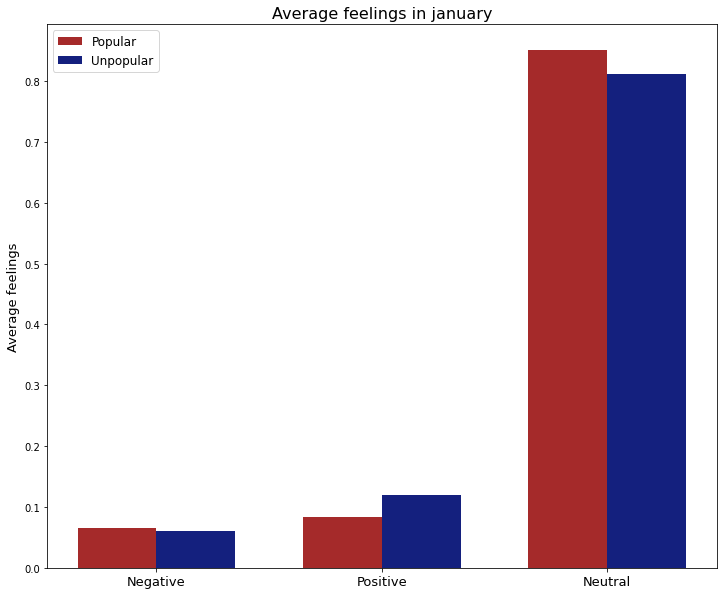

In [158]:
List_comparative_popular_january = [0]*3
List_comparative_none_popular_january = [0]*3

List_comparative_popular_january[0] = X.loc[(X['user_followers'] > 10000) & (X['month'] == 1) & (X['year'] == 2021),'Negative'].mean()
List_comparative_none_popular_january[0] = X.loc[(X['user_followers'] < 10000) & (X['month'] == 1) & (X['year'] == 2021),'Negative'].mean()
List_comparative_popular_january[1] = X.loc[(X['user_followers'] > 10000) & (X['month'] == 1) & (X['year'] == 2021),'Positive'].mean()
List_comparative_none_popular_january[1] = X.loc[(X['user_followers'] < 100000) & (X['month'] == 1) & (X['year'] == 2021),'Positive'].mean()
List_comparative_popular_january[2] = X.loc[(X['user_followers'] > 10000) & (X['month'] == 1) & (X['year'] == 2021),'Neutral'].mean()
List_comparative_none_popular_january[2] = X.loc[(X['user_followers'] < 10000) & (X['month'] == 1) & (X['year'] == 2021),'Neutral'].mean()

largeur_barre = 0.35 
names = ['Negative','Positive','Neutral']
x1 = range(len(names)) 
x2 = [i + largeur_barre for i in x1]
f = plt.figure(figsize=(12, 10))
plt.ylabel('Average feelings',fontsize = 13)
plt.title("Average feelings in january",fontsize = 16)
plt.bar(x1,List_comparative_popular_january,width=0.35, color = 'brown', linewidth = 2)
plt.bar(x2,List_comparative_none_popular_january ,width=0.35, color = '#14207E', linewidth = 2)
plt.xticks([r + largeur_barre / 2 for r in range(len(x1))],names,fontsize = 13)
plt.legend(['Popular','Unpopular'], fontsize = 12)
plt.show()

We would like to know if twitter tends to censure the accounts who provide negative opinions on the Pfizer.

**Step XVII: Pie chart on the distrubtion of verified and unverified user**

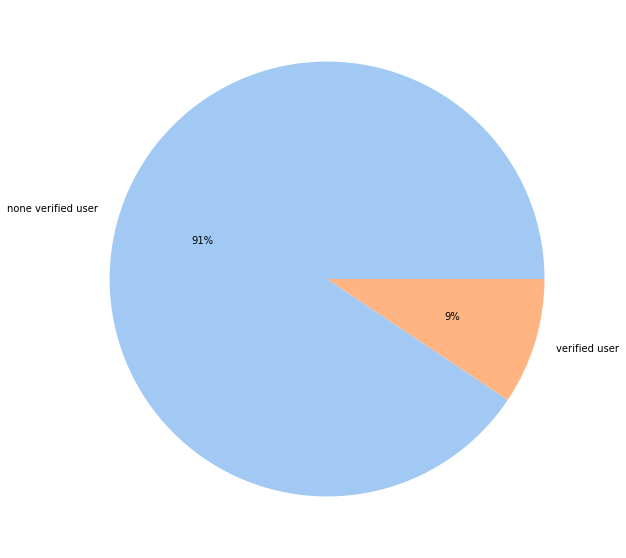

In [159]:
repartition = X['user_verified'].value_counts()
colors = sns.color_palette('pastel')[0:5]
labels = ['none verified user', 'verified user']
f = plt.figure(figsize=(10, 10))
plt.title("",fontsize = 16)
plt.pie(repartition, labels = labels, colors = colors, autopct='%.0f%%',)
plt.show()

The most person are none verified user. The verified user represent a small part of the population

**Step XVIII: Histogram on the average negative feelings in function of the account is verified**

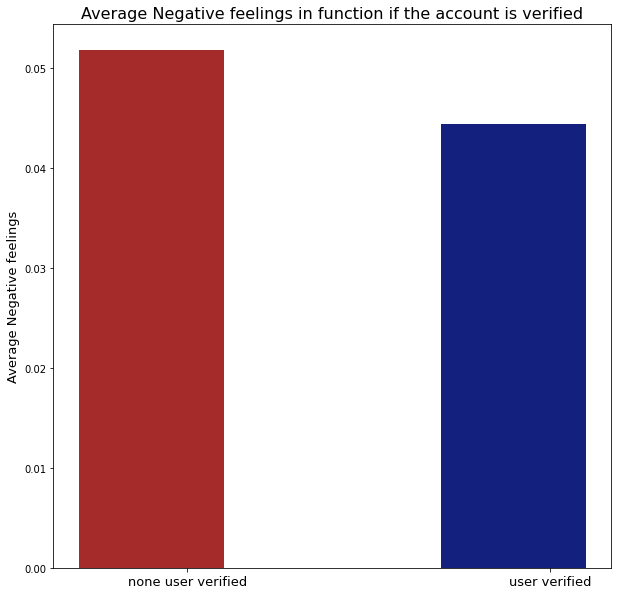

In [160]:
user_follower = [0]*2

user_follower[1] = X.loc[(X['user_verified'] == 1),'Negative'].mean()
user_follower[0] = X.loc[(X['user_verified'] == 0),'Negative'].mean()

largeur_barre = 0.2
names = ['none user verified','user verified']
x1 = range(len(names)) 
f = plt.figure(figsize=(10, 10))
plt.ylabel('Average Negative feelings',fontsize = 13)
plt.title("Average Negative feelings in function if the account is verified",fontsize = 16)
plt.bar(x1,user_follower,width=0.4, color = ['brown','#14207E'], linewidth = 2)

plt.xticks([r + largeur_barre / 2 for r in range(len(x1))],names,fontsize = 13)
plt.show()

In [161]:
pourcentage = ((user_follower[0] - user_follower[1])/user_follower[0])*100
print("User verified tends to have a good view on Pfizer %f more than none user verified" % (pourcentage))

User verified tends to have a good view on Pfizer 14.259572 more than none user verified


That means that we needs to be careful about our interpretation because twitter may filter the users.

**Step XIX : Word cloud for positive tweets according to vader**

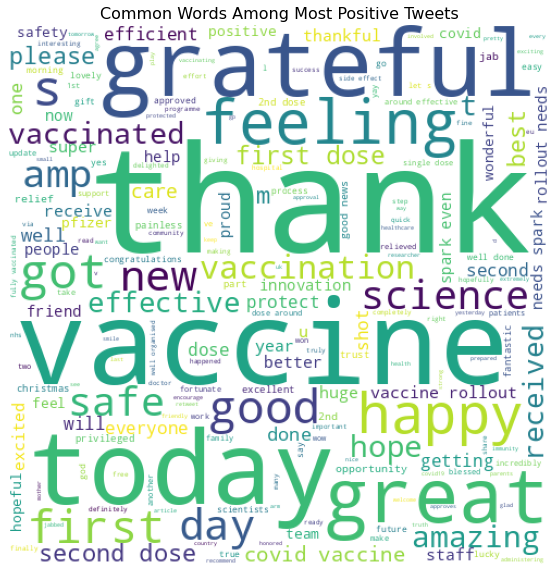

In [162]:
Word_Positive = X[X['Positive'].between(0.4,1)]
Word_Positive = ' '.join(Word_Positive.text)

positive = WordCloud(width=500,height=500,background_color='white').generate(Word_Positive)
f = plt.figure(figsize=(10, 10))
plt.title('Common Words Among Most Positive Tweets',fontsize=16)
plt.imshow(positive)
plt.axis('off')
plt.show()

**Step XX : Word cloud for negative tweets according to vader**

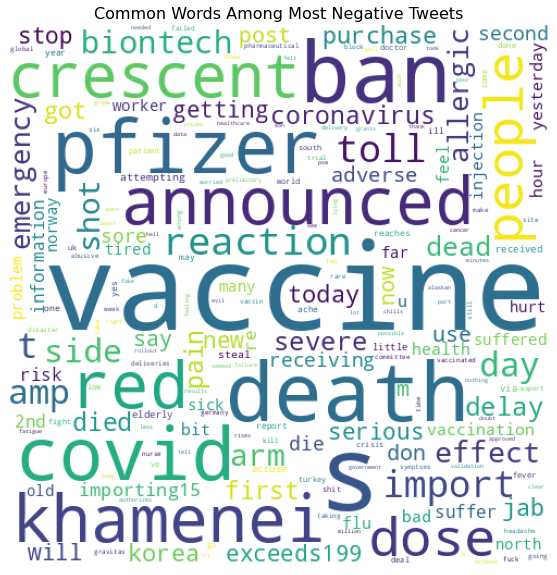

In [163]:
Word_Negative = X[X['Negative'].between(0.25,1)]
Word_Negative = ' '.join(Word_Negative.text)

negative = WordCloud(width=500,height=500,collocations = False,background_color='white').generate(Word_Negative)
f = plt.figure(figsize=(10, 10))
plt.title('Common Words Among Most Negative Tweets',fontsize=16)
plt.imshow(negative)
plt.axis('off')

plt.show()

We have taken Pfizer in order to simplifie the problem
Now, we will analyse for all vaccination in order to study the different point of view on different vaccination. we will import a different dataset and repeat the same data preprocessing.

X2 is a dataset larger than X with exactly the same feature

**Step XXI : Data pre-preproccessing for vaccination_all_tweets.csv**

In [164]:
from sklearn.impute import SimpleImputer
X2 = pd.read_csv("vaccination_all_tweets.csv")
X2["source"] = X2["source"].astype('category')
X2["source"] = X2["source"].cat.codes
X2 = X2.sort_values(by='date')
X2=X2.copy()
X2['date'] = pd.to_datetime(X2['date']).dt.date

X2["year"] = pd.DatetimeIndex(X2['date']).year
X2["month"] = pd.DatetimeIndex(X2['date']).month
X2["days"] = pd.DatetimeIndex(X2['date']).day

X2["text"] = X2["text"].apply(lambda x:re.sub(r"http\S+", "", x))
X2["text"] = X2["text"].apply(lambda x:re.sub(r'\B#\S+','',x))
X2["text"] = X2["text"].apply(lambda x:re.sub('@[^\s]+','',x))
X2["text"] = X2["text"].apply(lambda x:' '.join(re.findall(r'\w+', x)))
sid = SIA()
X2['sentiments'] = X2['text'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
X2['Positive'] = X2['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
X2['Neutral'] = X2['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
X2['Negative'] = X2['sentiments'].apply(lambda x: x['neg']+1*(10**-6))
X2["vader_category"] = X2["sentiments"].apply(lambda x: "Positive" if x['compound'] > 0.1 else "Negative" if x['compound'] < -0.1 else "Neutral")
X2 = X2.drop(["id","user_name","user_location","user_description","user_created","date","sentiments","is_retweet","favorites","user_friends","source","user_favourites","retweets","user_followers","user_verified"], axis=1)

We will observe if there is difference in sentiment between the both dataset

**Step XXII : Histogram on the comparaison of dataset**

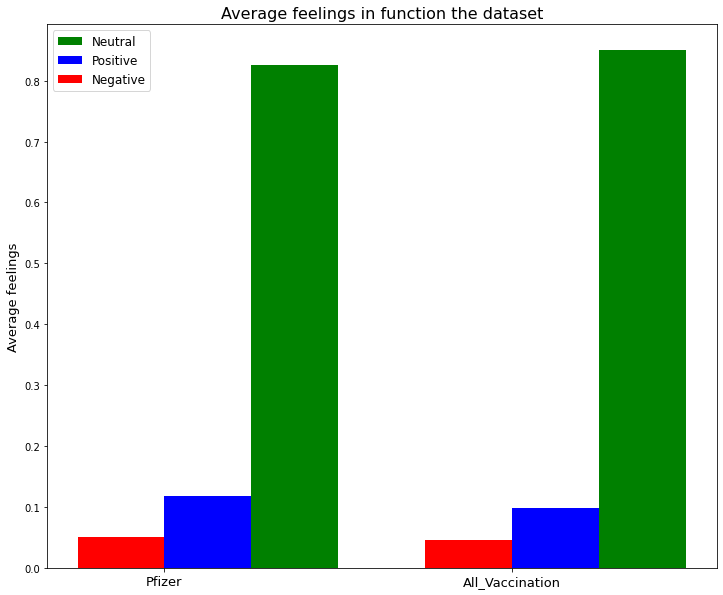

In [165]:
Mean_positive = [0]*2
Mean_positive[0] = X['Positive'].mean()
Mean_positive[1] = X2['Positive'].mean()

Mean_neutral = [0]*2
Mean_neutral[0] = X['Neutral'].mean()
Mean_neutral[1] = X2['Neutral'].mean()

Mean_negative = [0]*2
Mean_negative[0] = X['Negative'].mean()
Mean_negative[1] = X2['Negative'].mean()

largeur_barre = 0.25 
names = ['Pfizer', 'All_Vaccination']
x1 = range(len(names)) 
x2 = [i + largeur_barre for i in x1]
x3 = [i + 2*largeur_barre for i in x1]
f = plt.figure(figsize=(12, 10))
plt.ylabel('Average feelings',fontsize = 13)
plt.title("Average feelings in function the dataset",fontsize = 16)
plt.bar(x3,Mean_neutral,width=0.25, color = 'green', linewidth = 2)
plt.bar(x2,Mean_positive,width=0.25, color = 'blue', linewidth = 2)
plt.bar(x1,Mean_negative,width=0.25, color = 'red', linewidth = 2)
plt.xticks([r + largeur_barre / 2 for r in range(len(x1))],names,fontsize = 13)
plt.legend(['Neutral','Positive','Negative'],fontsize = 12)
plt.show()

**Step XXIII : Table on the comparaison of dataset**

In [166]:
from tabulate import tabulate
print('Positive feeling :\n')
print(tabulate([Mean_positive], headers=['Pfizer', 'All vaccination']))
print('\nNegative feeling :\n')
print(tabulate([Mean_negative], headers=['Pfizer', 'All vaccination']))
print('\nNeutral feeling :\n')
print(tabulate([Mean_neutral], headers=['Pfizer', 'All vaccination']))

Positive feeling :

  Pfizer    All vaccination
--------  -----------------
0.117156          0.0981105

Negative feeling :

   Pfizer    All vaccination
---------  -----------------
0.0511137          0.0451675

Neutral feeling :

  Pfizer    All vaccination
--------  -----------------
0.826039           0.850257


Generally, the opinion between Pfizer and other vaccination is similar.

**Step XXIV : Preprocessing on hastags**

In [167]:
X2['hashtags']=X2['hashtags'].str.lower()

**Step XXV : Data visualisation on hashtags**

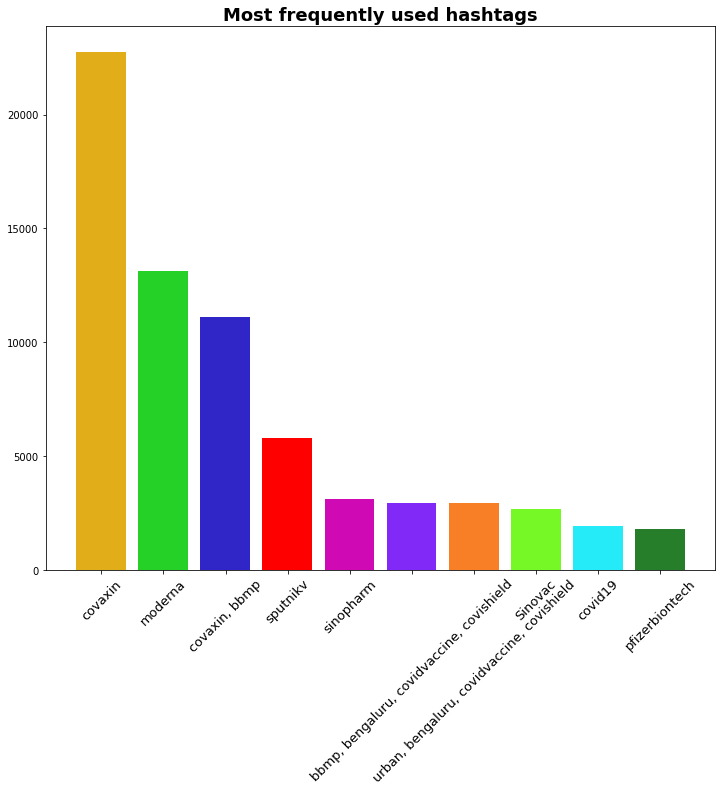

In [168]:
largeur_barre = 0.8 
Number_Participant = X2['hashtags'].value_counts().nlargest(10)
names = ['covaxin', 'moderna', 'covaxin, bbmp', 'sputnikv', 'sinopharm','bbmp, bengaluru, covidvaccine, covishield','urban, bengaluru, covidvaccine, covishield','Sinovac','covid19','pfizerbiontech']
x1 = range(len(names)) 
f = plt.figure(figsize=(12, 10))
plt.title("Most frequently used hashtags",fontsize = 18,fontweight='bold')
plt.bar(x1,Number_Participant,width=0.8, color = ['#E1AE1A','#25D027','#3026C7','red','#CF09B4','#8129F7','#F87F25','#75F825','#25EBF8','#267E2A'], linewidth = 2)
plt.xticks([r + 0.01 / 2 for r in range(len(x1))],names,fontsize = 13,rotation=45)
plt.show()

**Step XXVI: Data Encoding for hashtags**

In [169]:
X2["hashtags"] = X2["hashtags"].astype('category')
X2["hashtags"] = X2["hashtags"].cat.codes

**Step XXVII: Data visualization on the average negative feeling in function the vaccination**

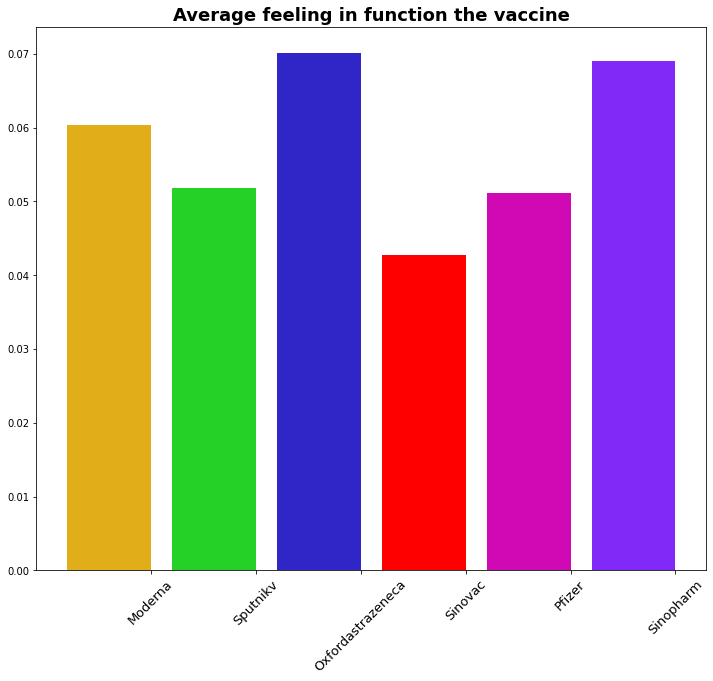

In [170]:
vaccine_comparison = [0]*6
vaccine_comparison[0] = X2.loc[(X2['hashtags'] == 32995),'Negative'].mean()
vaccine_comparison[1] = X2.loc[(X2['hashtags'] == 46355),'Negative'].mean()
vaccine_comparison[2] = X2.loc[(X2['hashtags'] == 36156),'Negative'].mean()
vaccine_comparison[3] = X2.loc[(X2['hashtags'] == 44484),'Negative'].mean()
vaccine_comparison[4] = X['Negative'].mean()
vaccine_comparison[5] = X2.loc[(X2['hashtags'] == 43290),'Negative'].mean()
names = ['Moderna', 'Sputnikv', 'Oxfordastrazeneca', 'Sinovac','Pfizer','Sinopharm']
x1 = range(len(names)) 
f = plt.figure(figsize=(12, 10))
plt.title("Average feeling in function the vaccine",fontsize = 18,fontweight='bold')
plt.bar(x1,vaccine_comparison,width=0.8, color = ['#E1AE1A','#25D027','#3026C7','red','#CF09B4','#8129F7','#F87F25','#75F825','#25EBF8','#267E2A'], linewidth = 2)
plt.xticks([r + largeur_barre / 2 for r in range(len(x1))],names,fontsize = 13,rotation=45)
plt.show()

**Step XXVIII: Data visualization on the average negative feeling in function the vaccination**

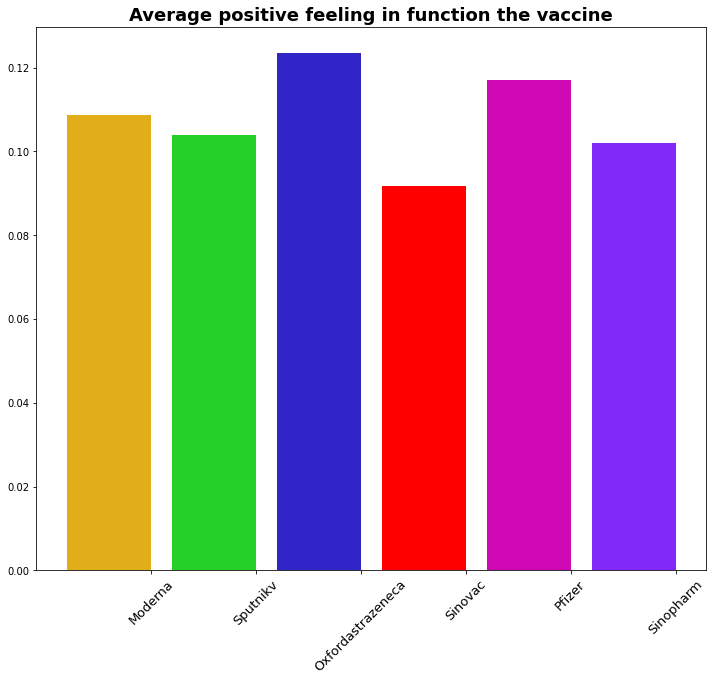

In [171]:
vaccine_comparison1 = [0]*6
vaccine_comparison1[0] = X2.loc[(X2['hashtags'] == 32995),'Positive'].mean()
vaccine_comparison1[1] = X2.loc[(X2['hashtags'] == 46355),'Positive'].mean()
vaccine_comparison1[2] = X2.loc[(X2['hashtags'] == 36156),'Positive'].mean()
vaccine_comparison1[3] = X2.loc[(X2['hashtags'] == 44484),'Positive'].mean()
vaccine_comparison1[4] = X['Positive'].mean()
vaccine_comparison1[5] = X2.loc[(X2['hashtags'] == 43290),'Positive'].mean()
names = ['Moderna', 'Sputnikv', 'Oxfordastrazeneca', 'Sinovac','Pfizer','Sinopharm']
x1 = range(len(names)) 
f = plt.figure(figsize=(12, 10))
plt.title("Average positive feeling in function the vaccine",fontsize = 18,fontweight='bold')
plt.bar(x1,vaccine_comparison1,width=0.8, color = ['#E1AE1A','#25D027','#3026C7','red','#CF09B4','#8129F7','#F87F25','#75F825','#25EBF8','#267E2A'], linewidth = 2)
plt.xticks([r + largeur_barre / 2 for r in range(len(x1))],names,fontsize = 13,rotation=45)
plt.show()

**Step XXIX: Data visualization on the ratio Negative/Positive feeling in function the vaccination**

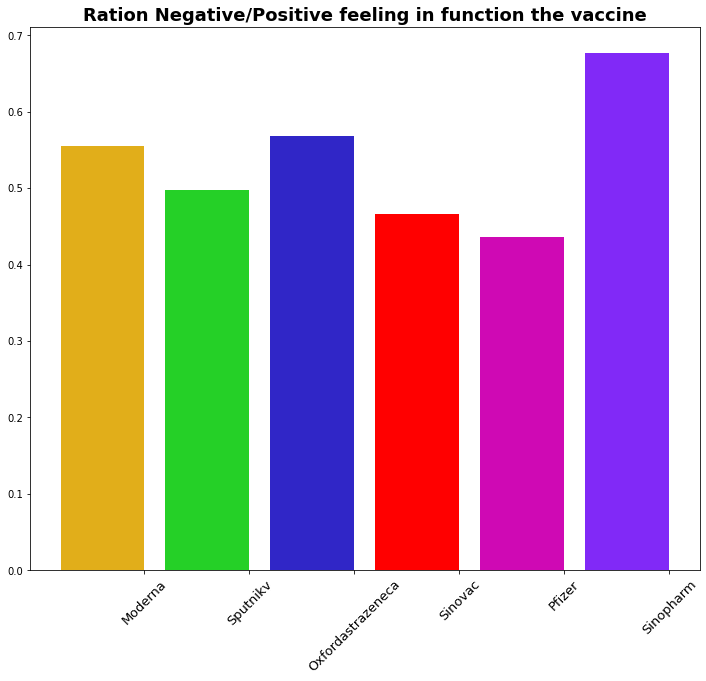

In [172]:
ratio = [0]*6
for i in range(len(vaccine_comparison)):
  ratio[i] = vaccine_comparison[i]/vaccine_comparison1[i]
names = ['Moderna', 'Sputnikv', 'Oxfordastrazeneca', 'Sinovac','Pfizer','Sinopharm']
x1 = range(len(names)) 
f = plt.figure(figsize=(12, 10))
plt.title("Ratio Negative/Positive feeling in function the vaccine",fontsize = 18,fontweight='bold')
plt.bar(x1,ratio,width=0.8, color = ['#E1AE1A','#25D027','#3026C7','red','#CF09B4','#8129F7','#F87F25','#75F825','#25EBF8','#267E2A'], linewidth = 2)
plt.xticks([r + largeur_barre / 2 for r in range(len(x1))],names,fontsize = 13,rotation=45)
plt.show()

The vaccine are appreciated differently. Sinopharm is not appreciated by the population while Pfizer get a better opinion by the population

**Step XXX : Creating polarity columns from Textblob**

In [173]:
from textblob import TextBlob
listTB = []
for tweet in X['text']:
  tweet = TextBlob(tweet)
  textblob = tweet.polarity
  listTB.append(textblob)
X['polarity'] = listTB

**Step XXXI : Creating Subjetivity columns from Textblob**

In [174]:
listTB = []
for tweet in X['text']:
  tweet = TextBlob(tweet)
  textblob = tweet.subjectivity
  listTB.append(textblob)
X['subjectivity'] = listTB

**Step XXXII : Creating category columns from Textblob**

In [175]:
X["textblob_category"] = X["polarity"].apply(lambda score: "Positive" if score > 0.1 else "Negative" if score < -0.1 else "Neutral")

**Step XXXIII : Data Encoding for Hashtags**

In [176]:
X["vader_category"] = X["vader_category"].replace('Positive', 1)
X["vader_category"] = X["vader_category"].replace('Neutral', 0)
X["vader_category"] = X["vader_category"].replace('Negative', -1)
X["textblob_category"] = X["textblob_category"].replace('Positive', 1)
X["textblob_category"] = X["textblob_category"].replace('Neutral', 0)
X["textblob_category"] = X["textblob_category"].replace('Negative', -1)

**Step XXXIV : Creating Correlation Matrix columns from Textblob**

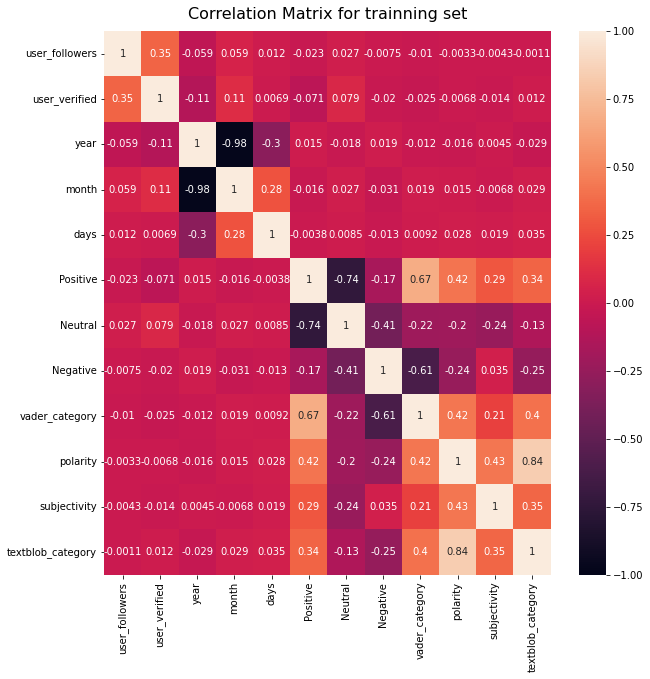

In [181]:
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(X.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Matrix for trainning set', fontdict={'fontsize':16}, pad=12);

we can observe some similarity between the result from Textblob and from Vader

**Step XXXV : Evaluation (Confusion Matrix and accuracy score)**

In [178]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(X['vader_category'], X["textblob_category"])
print(cm)
print()
print(accuracy_score(X['vader_category'], X["textblob_category"]))

[[ 293  883  236]
 [ 160 2440  831]
 [ 109 1120 2010]]

0.5868596881959911


58 % of the time, both model get the same result

**Step XXXVI : Word cloud for positive tweets according to Textblob**

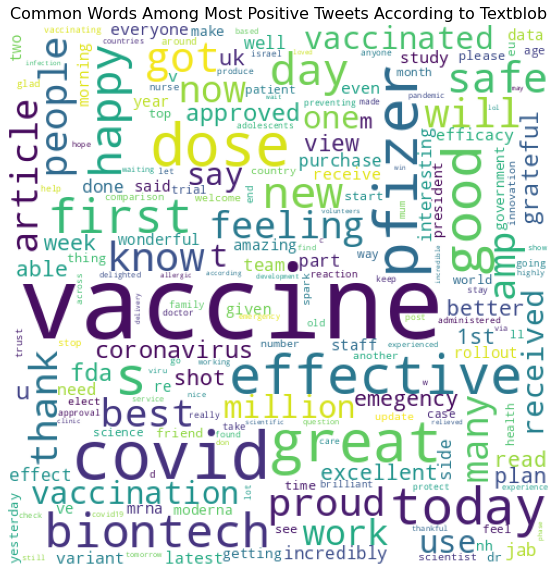

In [182]:
Word_Positive = X[X['polarity'].between(0.5,1)]
Word_Positive = ' '.join(Word_Positive.text)

positive = WordCloud(width=500,height=500,collocations = False,background_color='white').generate(Word_Positive)
f = plt.figure(figsize=(10, 10))
plt.title('Common Words Among Most Positive Tweets According to Textblob',fontsize=16)
plt.imshow(positive)
plt.axis('off')

plt.show()

The world cloud permit us to check if textblob is a good model

**Step XXXVII : Word cloud for negative tweets according to Textblob**

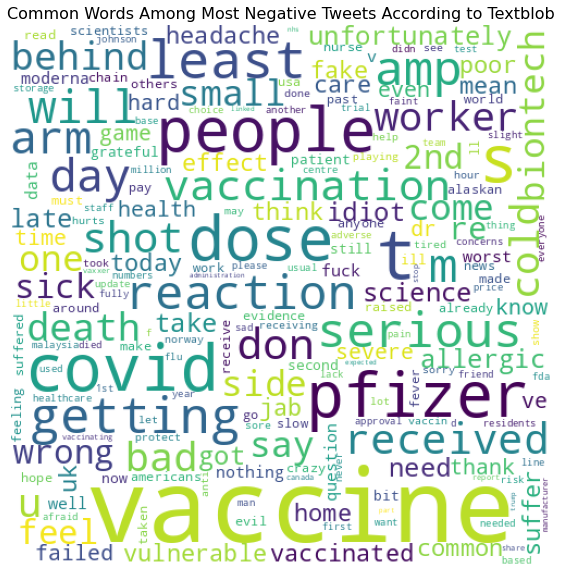

In [180]:
Word_Negative = X[X['polarity'].between(-1,-0.25)]
Word_Negative = ' '.join(Word_Negative.text)

negative = WordCloud(width=500,height=500,collocations = False,background_color='white').generate(Word_Negative)
f = plt.figure(figsize=(10, 10))
plt.title('Common Words Among Most Negative Tweets According to Textblob',fontsize=16)
plt.imshow(negative)
plt.axis('off')

plt.show()